# **Prueba Técnica Data Analyst**

## Análisis de Datos con SQL y Python (Pandas)

**Contexto:**
La empresa *BCA Operations* requiere analizar los datos de sus jugadores para:
- Identificar jugadores con **primer depósito** (FTD).
- Filtrar jugadores que cumplen con la condición de **CPA** (depósitos totales > 100 USD).
- Comparar los resultados con los registros internos para encontrar discrepancias.
- Visualizar información relevante de depósitos y jugadores.

Este Notebook sigue los pasos indicados en la prueba técnica y está cuidadosamente comentado para explicar la lógica y la metodología aplicada.

### **Objetivos Principales**
1. **SQL**: Crear una base de datos y tablas a partir de CSV. Realizar consultas para:
   - Identificar FTD.
   - Filtrar CPA.
   - Generar reporte de FTD y CPA por mes.
2. **Python (Pandas)**: Comparar con `internal_records.csv` y detectar discrepancias.
3. **Visualizaciones**: Graficar discrepancias, histórico de depósitos y otros insights.


In [18]:
# ==============
# 1. IMPORTACIONES
# ==============
# En esta celda realizamos la importación de todas las librerías necesarias.
# Se recomienda centralizar las importaciones para facilitar la lectura y el mantenimiento.

import sqlite3  # Para crear y gestionar la base de datos SQLite
import pandas as pd  # Para manipulación y análisis de datos
import numpy as np  # Para operaciones numéricas y manejo de arreglos
import matplotlib.pyplot as plt  # Para generación de gráficos en Python
import seaborn as sns  # Para gráficos estadísticos (facilita la visualización)

# Configuración de estilo para gráficos
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)  # Define el tamaño de los gráficos

## 2. **Carga de Datos**
En esta sección:
- Leemos los archivos CSV una sola vez.
- Convertimos las fechas a tipo datetime.
- Mostramos una vista previa para verificar la correcta carga de datos.

In [19]:
# Cargar datos en DataFrames de pandas.
# Se asume que los archivos se encuentran en la carpeta 'data'.
# Ajusta la ruta en caso de que estén en otra ubicación.

df_players = pd.read_csv("./data/players.csv")
df_traffic_sources = pd.read_csv("./data/traffic_sources.csv")
df_deposits = pd.read_csv("./data/deposits.csv")
df_internal_records = pd.read_csv("./data/internal_records.csv")

# Convertir columnas de fecha a tipo datetime (evita errores en operaciones de fechas)
df_players["registration_date"] = pd.to_datetime(df_players["registration_date"], errors='coerce')
df_traffic_sources["registration_date"] = pd.to_datetime(df_traffic_sources["registration_date"], errors='coerce')
df_deposits["deposit_date"] = pd.to_datetime(df_deposits["deposit_date"], errors='coerce')
df_internal_records["month"] = pd.to_datetime(df_internal_records["month"], errors='coerce')

print("Datos cargados y convertidos correctamente.")

# Muestra de los primeros registros de cada DataFrame
display(df_players.head())
display(df_traffic_sources.head())
display(df_deposits.head())
display(df_internal_records.head())

Datos cargados y convertidos correctamente.


,player_id,name,registration_date,country
0,23b8c1e9-3924-46de-beb1-3b9046685257,Derek Anderson,2023-07-27,France
1,e465e150-bd9c-46b3-ad3c-2d6d1a3d1fa7,Michael Martinez,2023-02-28,Niue
2,0822e8f3-6c03-4199-972a-846916419f82,Cynthia Moore,2022-01-24,Mexico
3,815ef6d1-3b8f-4a18-b7f8-a88b17fc695a,Jason Walker,2023-04-13,Tajikistan
4,b74d0fb1-32e7-4629-8fad-c1a606cb0fb3,Julia Wilson,2023-05-20,Syrian Arab Republic


,player_id,trafficker,cost_of_acquisition,registration_date
0,23b8c1e9-3924-46de-beb1-3b9046685257,Trafficker_5,111.22,2023-07-27
1,e465e150-bd9c-46b3-ad3c-2d6d1a3d1fa7,Trafficker_3,234.12,2023-02-28
2,0822e8f3-6c03-4199-972a-846916419f82,Trafficker_9,71.73,2022-01-24
3,815ef6d1-3b8f-4a18-b7f8-a88b17fc695a,Trafficker_7,57.95,2023-04-13
4,b74d0fb1-32e7-4629-8fad-c1a606cb0fb3,Trafficker_2,104.66,2023-05-20


,deposit_id,player_id,deposit_amount,deposit_date
0,f64e3dfc-bfbe-4c7a-afc5-97382fb21e66,7631de9d-dde9-4863-a2bd-33886db99102,351.49,2023-01-01
1,4c636e95-025f-4543-8997-623ae0723d96,f10c718b-1eb0-438a-a75d-d5af3c365296,321.08,2023-12-20
2,fba57cc8-edaf-4766-9b78-0ede9a4ffc0c,a76afde6-ce9e-4a11-bcbb-4e59fbddcf7c,68.91,2023-06-25
3,a42d0cd7-fd35-4f6a-b450-388748d90846,4dd8eb85-b04d-4376-b7fc-97031fd5a423,390.79,2023-10-11
4,f0458043-e3a6-4a70-be71-0b558639bd41,b07aa066-7354-45ea-a894-9b8d00af5b3a,428.14,2023-05-29


,month,expected_ftd,expected_cpa
0,2022-01-01,30,21
1,2022-02-01,23,13
2,2022-03-01,25,21
3,2022-04-01,48,38
4,2022-05-01,47,40


## 3. **Creación de la Base de Datos y Tablas SQL**
En esta sección:
1. Conectamos/creamos la base de datos `gaming_data.db` con **SQLite**.
2. Definimos las tablas necesarias: `players`, `traffic_sources`, `deposits`, `internal_records`.
3. Insertamos los datos directamente desde los DataFrames a la base de datos.

In [20]:
# Conectar a la base de datos (se creará si no existe)
conn = sqlite3.connect("gaming_data.db")
cursor = conn.cursor()

# Creamos las tablas necesarias si no existen.
# Usamos la instrucción EXECUTESCRIPT para ejecutar múltiples comandos SQL.

cursor.executescript('''
    CREATE TABLE IF NOT EXISTS players (
        player_id INTEGER PRIMARY KEY,
        name TEXT,
        country TEXT,
        registration_date DATE
    );
    
    CREATE TABLE IF NOT EXISTS traffic_sources (
        player_id INTEGER,
        trafficker TEXT,
        cost_of_acquisition REAL,
        registration_date DATE,
        source TEXT
    );
    
    CREATE TABLE IF NOT EXISTS deposits (
        deposit_id INTEGER PRIMARY KEY,
        player_id INTEGER,
        deposit_date DATE,
        deposit_amount REAL
    );
    
    CREATE TABLE IF NOT EXISTS internal_records (
        month DATE,
        expected_ftd INTEGER,
        expected_cpa INTEGER,
        status TEXT
    );
''')

conn.commit()
print("Tablas creadas o verificadas correctamente.")

# Cargamos los datos de los DataFrames a las tablas de SQLite.
# if_exists='replace' indica que se reemplazará la tabla si ya existe contenido.

df_players.to_sql("players", conn, if_exists="replace", index=False)
df_traffic_sources.to_sql("traffic_sources", conn, if_exists="replace", index=False)
df_deposits.to_sql("deposits", conn, if_exists="replace", index=False)
df_internal_records.to_sql("internal_records", conn, if_exists="replace", index=False)

print("Datos insertados en la base de datos correctamente.")

Tablas creadas o verificadas correctamente.
Datos insertados en la base de datos correctamente.


## 4. **Identificar el Primer Depósito (FTD)**
El **FTD (First Time Deposit)** se define como la fecha mínima de depósito por jugador.
- Creamos una tabla auxiliar `first_time_deposits` para almacenar el `player_id` y la fecha de su primer depósito.

In [21]:
# Eliminamos la tabla si ya existe, para recalcular
cursor.execute("DROP TABLE IF EXISTS first_time_deposits;")
conn.commit()

# Consulta para crear la tabla con el primer depósito de cada jugador (fecha mínima)
cursor.execute('''
    CREATE TABLE first_time_deposits AS
    SELECT
        player_id,
        MIN(deposit_date) AS first_deposit_date
    FROM deposits
    GROUP BY player_id;
''')
conn.commit()

print("Tabla 'first_time_deposits' creada correctamente (identifica FTD).")

Tabla 'first_time_deposits' creada correctamente (identifica FTD).


## 5. **Filtrar Jugadores CPA**
Según la prueba técnica, un jugador se considera **CPA** si la suma de sus depósitos supera los **100 USD** (o el valor indicado).

In [22]:
# Eliminamos la tabla si existe, para recalcular
cursor.execute("DROP TABLE IF EXISTS cpa_players;")
conn.commit()

# Creamos la tabla con los jugadores que superan un total de 100 USD en depósitos
cursor.execute('''
    CREATE TABLE cpa_players AS
    SELECT
        player_id,
        SUM(deposit_amount) AS total_deposits
    FROM deposits
    GROUP BY player_id
    HAVING total_deposits > 100;
''')
conn.commit()

print("Tabla 'cpa_players' creada correctamente (jugadores con depósitos > 100 USD).")

Tabla 'cpa_players' creada correctamente (jugadores con depósitos > 100 USD).


## 6. **Reporte de FTD por Mes**
Generamos un reporte con la **cantidad de jugadores** que realizaron su primer depósito **cada mes**.

In [23]:
# Consulta SQL para obtener el conteo de FTD por mes (usando strftime('%Y-%m', fecha))

query_ftd_month = '''
SELECT 
    strftime('%Y-%m', first_deposit_date) AS month,
    COUNT(player_id) AS ftd_count
FROM first_time_deposits
GROUP BY month
ORDER BY month;
'''

# Ejecutamos la consulta y convertimos a DataFrame
df_ftd_report = pd.read_sql(query_ftd_month, conn)
print("Reporte de FTD por mes:")
display(df_ftd_report)

Reporte de FTD por mes:


,month,ftd_count
0,2022-01,1
1,2022-03,4
2,2022-04,4
3,2022-05,3
4,2022-06,5
5,2022-07,11
6,2022-08,4
7,2022-09,9
8,2022-10,5
9,2022-11,13


## 7. **Reporte de CPA por Mes**
Generamos un reporte con la **cantidad de jugadores** que cumplen la condición de CPA **cada mes**.

In [24]:
# Consulta SQL para obtener el conteo de CPA por mes.
# Se utiliza la tabla cpa_players en JOIN con deposits para extraer la fecha.

query_cpa_month = '''
SELECT 
    strftime('%Y-%m', d.deposit_date) AS month,
    COUNT(DISTINCT d.player_id) AS cpa_count
FROM deposits d
JOIN cpa_players c ON d.player_id = c.player_id
GROUP BY month
ORDER BY month;
'''

# Ejecutamos la consulta y lo llevamos a un DataFrame
df_cpa_report = pd.read_sql(query_cpa_month, conn)
print("Reporte de CPA por mes:")
display(df_cpa_report)

Reporte de CPA por mes:


,month,cpa_count
0,2022-01,1
1,2022-03,5
2,2022-04,4
3,2022-05,4
4,2022-06,6
5,2022-07,14
6,2022-08,8
7,2022-09,14
8,2022-10,9
9,2022-11,20


## 8. **Análisis de Calidad de Datos**
En esta sección:
1. Comparamos los resultados de FTD y CPA que calculamos con `internal_records.csv`.
2. Buscamos **discrepancias** por mes entre nuestros datos y los registros internos.
3. Guardamos en un DataFrame las diferencias detectadas.

In [26]:
# Convertir la columna "month" a tipo datetime en todos los DataFrames
df_ftd_report["month"] = pd.to_datetime(df_ftd_report["month"], errors='coerce')
df_cpa_report["month"] = pd.to_datetime(df_cpa_report["month"], errors='coerce')
df_internal_records["month"] = pd.to_datetime(df_internal_records["month"], errors='coerce')

# Convertir la fecha a periodo (AÑO-MES) para hacer el merge correctamente
df_ftd_report["month_period"] = df_ftd_report["month"].dt.to_period("M")
df_cpa_report["month_period"] = df_cpa_report["month"].dt.to_period("M")
df_internal_records["month_period"] = df_internal_records["month"].dt.to_period("M")

# Unimos el reporte de FTD con el DataFrame de internal_records
df_comparison = df_internal_records.merge(
    df_ftd_report[["month_period", "ftd_count"]],
    how="left",
    on="month_period"
)

# Unimos el reporte de CPA
df_comparison = df_comparison.merge(
    df_cpa_report[["month_period", "cpa_count"]],
    how="left",
    on="month_period"
)

# Renombramos columnas para unificar criterio
df_comparison.rename(columns={
    "expected_ftd": "ftd_expected",
    "expected_cpa": "cpa_expected"
}, inplace=True)

# Rellenamos NaN con 0 para evitar problemas de comparación
df_comparison[["ftd_count", "cpa_count"]] = df_comparison[["ftd_count", "cpa_count"]].fillna(0)

# Calculamos discrepancias
df_comparison["ftd_discrepancy"] = df_comparison["ftd_count"] - df_comparison["ftd_expected"]
df_comparison["cpa_discrepancy"] = df_comparison["cpa_count"] - df_comparison["cpa_expected"]

print("Discrepancias FTD y CPA vs. registros internos:")
display(df_comparison)

Discrepancias FTD y CPA vs. registros internos:


,month,ftd_expected,cpa_expected,month_period,ftd_count,cpa_count,ftd_discrepancy,cpa_discrepancy
0,2022-01-01,30,21,2022-01,1.0,1.0,-29.0,-20.0
1,2022-02-01,23,13,2022-02,0.0,0.0,-23.0,-13.0
2,2022-03-01,25,21,2022-03,4.0,5.0,-21.0,-16.0
3,2022-04-01,48,38,2022-04,4.0,4.0,-44.0,-34.0
4,2022-05-01,47,40,2022-05,3.0,4.0,-44.0,-36.0
5,2022-06-01,58,51,2022-06,5.0,6.0,-53.0,-45.0
6,2022-07-01,46,42,2022-07,11.0,14.0,-35.0,-28.0
7,2022-08-01,33,25,2022-08,4.0,8.0,-29.0,-17.0
8,2022-09-01,27,22,2022-09,9.0,14.0,-18.0,-8.0
9,2022-10-01,47,46,2022-10,5.0,9.0,-42.0,-37.0


### 8.1 Visualización de Discrepancias
Graficamos las diferencias en **FTD** y **CPA** por mes para detectar patrones de error.

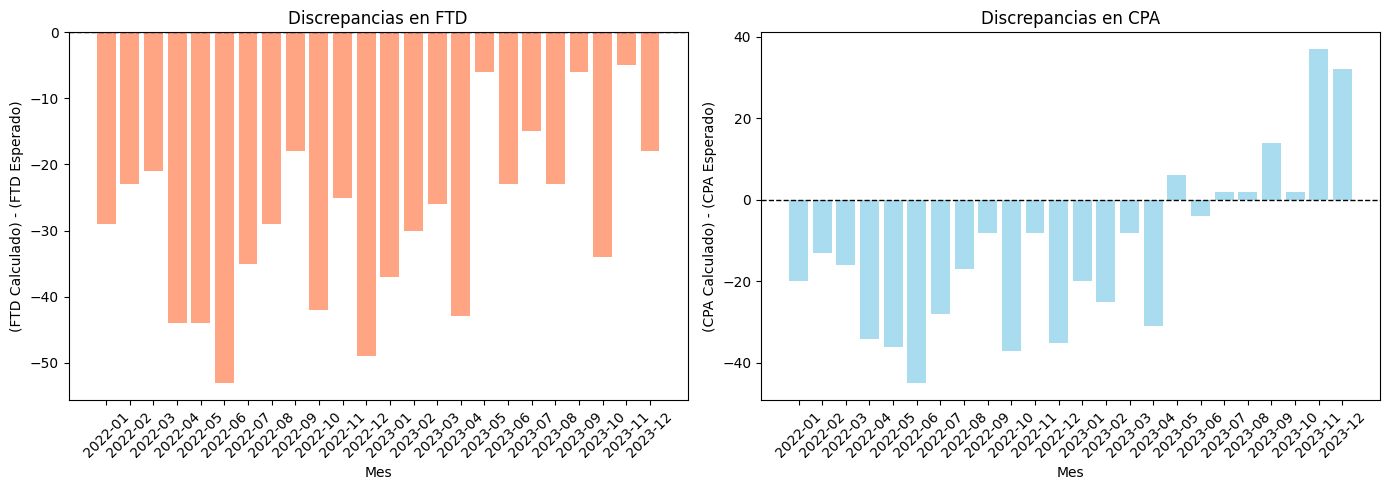

In [27]:
# Filtramos los meses con discrepancias distintas de 0
df_discrepant = df_comparison[
    (df_comparison["ftd_discrepancy"] != 0) | (df_comparison["cpa_discrepancy"] != 0)
]

if not df_discrepant.empty:
    # Configuramos la figura con 2 subplots en la misma fila
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Subplot 1: discrepancias FTD
    ax[0].bar(
        df_discrepant["month_period"].astype(str),
        df_discrepant["ftd_discrepancy"],
        color='coral', alpha=0.7
    )
    ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
    ax[0].set_title("Discrepancias en FTD")
    ax[0].set_xlabel("Mes")
    ax[0].set_ylabel("(FTD Calculado) - (FTD Esperado)")
    ax[0].tick_params(axis='x', rotation=45)

    # Subplot 2: discrepancias CPA
    ax[1].bar(
        df_discrepant["month_period"].astype(str),
        df_discrepant["cpa_discrepancy"],
        color='skyblue', alpha=0.7
    )
    ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
    ax[1].set_title("Discrepancias en CPA")
    ax[1].set_xlabel("Mes")
    ax[1].set_ylabel("(CPA Calculado) - (CPA Esperado)")
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron discrepancias en los datos para graficar.")

## 9. **Análisis de Depósitos**
En esta parte:
- Mostramos el histórico de dinero depositado mes a mes.
- Identificamos el jugador que más depositó.
- Realizamos una visualización de la distribución de depósitos por jugador.


In [28]:
# Convertimos la columna deposit_amount a numérico por si hay valores inválidos.
df_deposits["deposit_amount"] = pd.to_numeric(df_deposits["deposit_amount"], errors='coerce')

# Creamos la columna 'month_year' (periodo) para agrupar los depósitos mensualmente
df_deposits["month_year"] = df_deposits["deposit_date"].dt.to_period("M")

# Calculamos el total de depósitos por mes
df_monthly_deposits = df_deposits.groupby("month_year")["deposit_amount"].sum().reset_index()

# Identificamos al jugador con mayor monto total depositado
df_deposits_by_player = df_deposits.groupby("player_id")["deposit_amount"].sum().reset_index()
max_deposit_row = df_deposits_by_player.loc[df_deposits_by_player["deposit_amount"].idxmax()]
player_with_max = max_deposit_row["player_id"]
max_deposit_amount = max_deposit_row["deposit_amount"]

print(f"Jugador con más depósitos: ID {player_with_max} con un total de ${max_deposit_amount:.2f}.")

print("\nTotal de depósitos por mes:")
display(df_monthly_deposits)

Jugador con más depósitos: ID 8babce3b-2628-4bfb-a767-dceab0e6a969 con un total de $2156.42.

Total de depósitos por mes:


,month_year,deposit_amount
0,2022-01,175.17
1,2022-03,1610.36
2,2022-04,1363.66
3,2022-05,1286.24
4,2022-06,1772.60
5,2022-07,2837.41
6,2022-08,2221.95
7,2022-09,3575.38
8,2022-10,3210.16
9,2022-11,5550.11


### 9.1 **Visualizaciones de Depósitos**
1. **Histórico de dinero depositado**: línea temporal.
2. **Distribución de depósitos por jugador**: histograma.
3. **Impacto de fuentes de tráfico** en el total de depósitos.

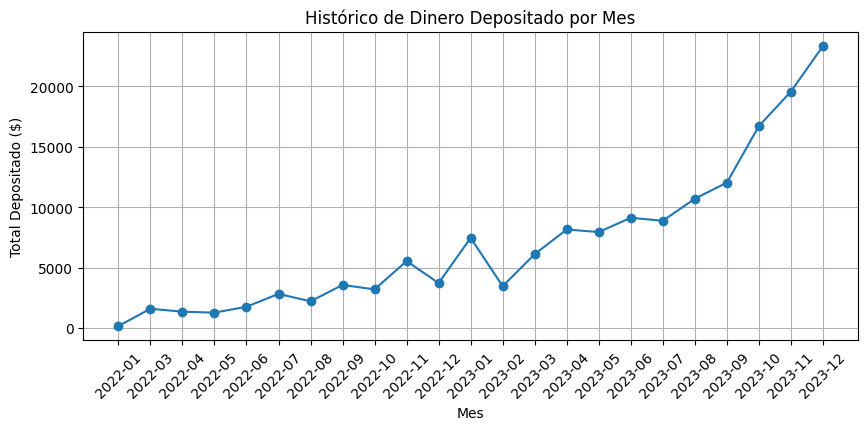

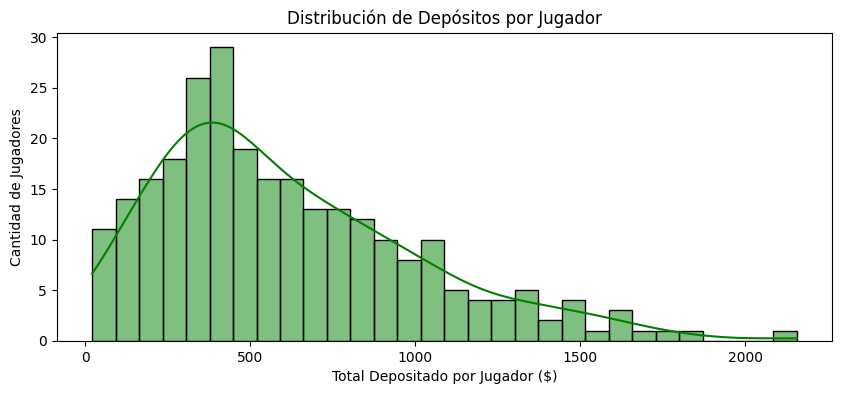

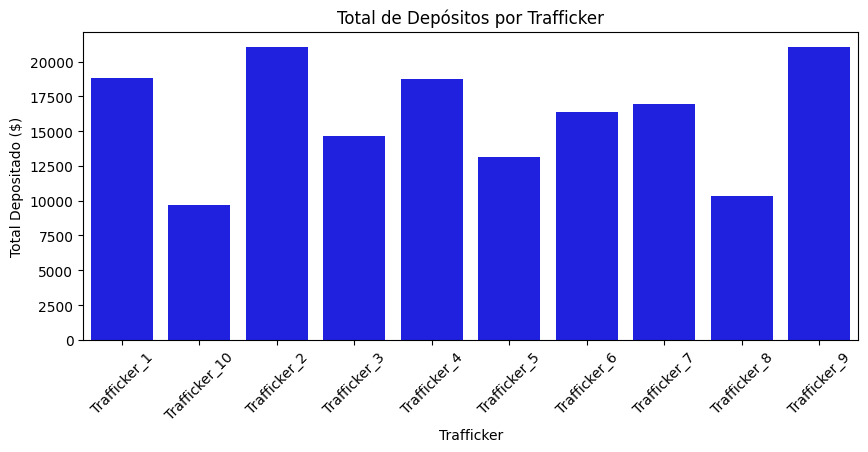

In [29]:
# 1. Gráfico del histórico de dinero depositado por mes
plt.figure(figsize=(10, 4))
plt.plot(
    df_monthly_deposits["month_year"].astype(str),
    df_monthly_deposits["deposit_amount"],
    marker='o',
    linestyle='-'
)
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Total Depositado ($)")
plt.title("Histórico de Dinero Depositado por Mes")
plt.grid(True)
plt.show()

# 2. Distribución de depósitos por jugador
plt.figure(figsize=(10, 4))
sns.histplot(df_deposits_by_player["deposit_amount"], bins=30, kde=True, color='green')
plt.xlabel("Total Depositado por Jugador ($)")
plt.ylabel("Cantidad de Jugadores")
plt.title("Distribución de Depósitos por Jugador")
plt.show()

# 3. Impacto de las fuentes de tráfico (trafficker) en el total de depósitos
# Unir los DataFrames: df_deposits y df_traffic_sources para ver la relación

df_merged = df_deposits.merge(df_traffic_sources, on="player_id", how="left", suffixes=("_dep", "_ts"))
df_traffic_deposits = df_merged.groupby("trafficker")["deposit_amount"].sum().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(data=df_traffic_deposits, x="trafficker", y="deposit_amount", color='blue')
plt.xticks(rotation=45)
plt.xlabel("Trafficker")
plt.ylabel("Total Depositado ($)")
plt.title("Total de Depósitos por Trafficker")
plt.show()

# **Conclusiones y Próximos Pasos**
1. **FTD y CPA**: Hemos identificado correctamente los jugadores que hicieron su primer depósito (FTD) y aquellos que superan los 100 USD en total depositado (CPA).
2. **Discrepancias**: Se compararon los valores calculados con la tabla interna `internal_records`. Los meses con diferencias se muestran en los gráficos de discrepancias.
3. **Análisis de Depósitos**: Observamos el histórico mensual, el jugador de máximo depósito y la distribución general. También podemos ver qué **traffickers** generan mayores volúmenes de depósito.
4. **Próximos pasos**:
   - Integrar estos hallazgos en **Power BI** para un dashboard más completo.
   - Validar con mayor detalle los meses con discrepancias.
   - Ajustar y optimizar los costos de adquisición si se identifican fuentes de tráfico poco rentables.

### **Fin de la Prueba Técnica**
Este Notebook cumple con los objetivos solicitados:
- Creación y carga de datos en SQLite.
- Identificación y reporte de FTD y CPA.
- Comparación con registros internos y detección de discrepancias.
- Visualizaciones clave de depósitos.

¡Gracias por tu atención!